In [1]:
import requests, numpy as np
from nltk import word_tokenize

chapter = 1
url = 'http://faculty.georgetown.edu/jod/ulysses/ulys%d.txt' % chapter

response = requests.get(url)
raw = response.text

raw[50:100]

'   * Stately, plump Buck Mulligan came from the st'

In [2]:
tokens = word_tokenize(raw)
tokens[:10]

['[', '1', ']', '*', 'Stately', ',', 'plump', 'Buck', 'Mulligan', 'came']

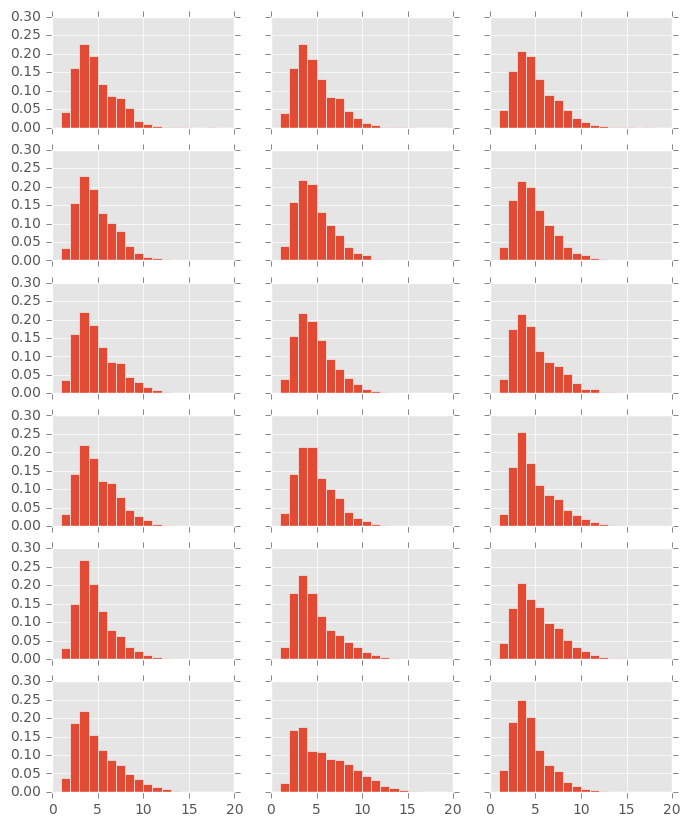

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

f, axarr = plt.subplots(6,3,sharex=True,sharey=True,figsize=(8,10))

for chapter in np.arange(1,19): #18 chapters in ulysses
    if chapter < 18: 
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys%d.txt' % chapter
    else:    
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys18dr.txt'
    
    response = requests.get(url)
    tokens = word_tokenize(response.text)
    word_len = [len(x) for x in tokens if x.isalpha()]
    #print(np.mean(word_len))
    axarr[int(np.floor((chapter-1)/3)),(chapter-1)%3].hist(word_len,normed=True, range=(0,20),bins=20)

https://bbengfort.github.io/tutorials/2016/05/19/text-classification-nltk-sckit-learn.html

In [4]:
from nltk.corpus import stopwords as sw
from nltk import wordpunct_tokenize
from nltk import sent_tokenize
from nltk import pos_tag
import string
import pandas as pd
import numpy as np

punct = string.punctuation
stopwords = sw.words('english')

for chapter in np.arange(1,19): #18 chapters in ulysses
    
    #get the book
    if chapter < 18: 
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys%d.txt' % chapter
    else:    
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys18dr.txt'
    response = requests.get(url)
    
    d = {'FW':[], 
         'ADJ':[], 
         'NOUN':[],
         'ADVB':[],
         'VERB':[],
         'WORLEN':[],
         'SENLEN':[]}
    
    for sent in sent_tokenize(response.text):
        FW,ADJ,NOUN,ADVB,VERB,SENLEN,WORLEN = 0,0,0,0,0,0,0
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # Apply preprocessing to the token
            token = token.lower() 
            token = token.strip() 
            token = token.strip('_')
            token = token.strip('*') 

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            #remove numbers
            if token.isdigit():
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            #get word type (http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
            if tag[0]=='F':FW+=1
            elif tag[0]=='J':ADJ+=1
            elif tag[0]=='N':NOUN+=1
            elif tag[0]=='R':ADVB+=1
            elif tag[0]=='V':VERB+=1

            #sentence length
            SENLEN+=1

            #word length
            WORLEN+=len(token)

        #if the sentence was all stopwords or otherwise 0 meaningful words
        if SENLEN==0: 
            continue
        #update data if there is data to update
        d['FW'].append(FW/SENLEN)
        d['ADJ'].append(ADJ/SENLEN)
        d['NOUN'].append(NOUN/SENLEN)
        d['ADVB'].append(ADVB/SENLEN)
        d['VERB'].append(VERB/SENLEN)
        d['WORLEN'].append(WORLEN/SENLEN)
        d['SENLEN'].append(SENLEN)

    temp_df = pd.DataFrame(d)
    temp_df['Chapter'] = np.ones((len(d['ADJ']),1))*chapter
    
    if chapter == 1:
        df = temp_df
    else:
        df = df.append(temp_df)

In [5]:
np.shape(df)

(22446, 8)

In [6]:
Y = df.pop('Chapter')
X = df.as_matrix()

In [7]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(class_weight='balanced')
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [8]:
from sklearn.metrics import accuracy_score
y_pred = logreg.predict(X)
accuracy_score(Y, y_pred)

0.14929163325314088

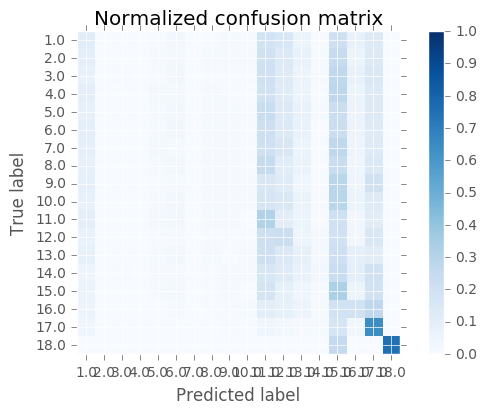

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y, y_pred)

def plot_confusion_matrix(cm, Y, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap,vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(Y)))
    plt.xticks(tick_marks, np.unique(Y))
    plt.yticks(tick_marks, np.unique(Y))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, Y, title='Normalized confusion matrix')


Okay, so that wasn't the best. I am going to try a neural network instead. I am using this guide to start - https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [10]:
all_text = []
for chapter in np.arange(1,19): #18 chapters in ulysses
    
    #get the book
    if chapter < 18: 
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys%d.txt' % chapter
    else:    
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys18dr.txt'
    response = requests.get(url)
    
    all_text.append(response.text)

In [11]:
from keras.preprocessing.text import Tokenizer

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 40000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using Theano backend.


Found 30137 unique tokens.


In [114]:
punct = string.punctuation

sequences, chapter_label = [], []
for chapter in np.arange(1,19): #18 chapters in ulysses
    
    #get the book
    if chapter < 18: 
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys%d.txt' % chapter
    else:    
        url = 'http://faculty.georgetown.edu/jod/ulysses/ulys18dr.txt'
    response = requests.get(url)
    
    for sent in sent_tokenize(response.text):
        sent_words = []
        for token in wordpunct_tokenize(sent):
            
            # Apply preprocessing to the token
            token = token.lower() 
            token = token.strip() 
            token = token.strip('_')
            token = token.strip('*') 

            #remove numbers
            if token.isdigit():
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue
            
            if token:
                sent_words.append(token)
        
        if len(sent_words)>0:
            sequences.append(tokenizer.texts_to_sequences(sent_words))
            ch_label.append(chapter)

In [153]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

num_chapters = len(np.unique(ch_label))

data = np.array([pad_sequences(np.array(sent).T, maxlen=MAX_SEQUENCE_LENGTH) for sent in sequences])

#data, chapter_label = [], []
#for chapter,sent in zip(ch_label,sequences):
#    seq = pad_sequences(np.array(sent).T,maxlen=MAX_SEQUENCE_LENGTH)
#    if seq.shape[0]==0:
#        continue
#    else:
#        data.append(seq)
#        one_hot = np.zeros(len(np.unique(ch_label)))
#        one_hot[chapter-1] = 1
#        #chapter_label.append(to_categorical(chapter))
#        chapter_label.append(one_hot)
    
chapter_label = to_categorical(np.asarray(ch_label))

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', chapter_label.shape)

Shape of data tensor: (23042,)
Shape of label tensor: (46084, 19)


In [30]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
chapter_label = chapter_label[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = chapter_label[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = chapter_label[-nb_validation_samples:]

http://nlp.stanford.edu/projects/glove/

In [32]:
import os

BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove.6B/'
#I would like to use one of the larger ones given the huge vocab of this book, but i don't have the ram

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [34]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [35]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [38]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(num_chapters, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=2, batch_size=128)

Exception: Error when checking model input: expected input_2 to have shape (None, 1000) but got array with shape (18434, 1)

In [42]:
np.squeeze(x_train).shape

(18434,)